In [1]:
# Install the OpenSlide C library and Python bindings
!apt-get install openslide-tools
!pip install openslide-python

Reading package lists... Done
Building dependency tree       
Reading state information... Done
openslide-tools is already the newest version (3.4.1+dfsg-2).
The following packages were automatically installed and are no longer required:
  cuda-cufft-10-1 cuda-cufft-dev-10-1 cuda-curand-10-1 cuda-curand-dev-10-1
  cuda-cusolver-10-1 cuda-cusolver-dev-10-1 cuda-cusparse-10-1
  cuda-cusparse-dev-10-1 cuda-license-10-2 cuda-npp-10-1 cuda-npp-dev-10-1
  cuda-nsight-10-1 cuda-nsight-compute-10-1 cuda-nsight-systems-10-1
  cuda-nvgraph-10-1 cuda-nvgraph-dev-10-1 cuda-nvjpeg-10-1
  cuda-nvjpeg-dev-10-1 cuda-nvrtc-10-1 cuda-nvrtc-dev-10-1 cuda-nvvp-10-1
  libcublas10 libnvidia-common-430 nsight-compute-2019.5.0
  nsight-systems-2019.5.2
Use 'apt autoremove' to remove them.
0 upgraded, 0 newly installed, 0 to remove and 5 not upgraded.


# mount drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
from openslide import open_slide, __library_version__ as openslide_version
import os
from PIL import Image
from skimage.color import rgb2gray
import random
from sklearn.model_selection import train_test_split
%tensorflow_version 2.x
import tensorflow as tf
from matplotlib.colors import Normalize

TensorFlow 2.x selected.


In [0]:
# See https://openslide.org/api/python/#openslide.OpenSlide.read_region
# Note: x,y coords are with respect to level 0.
# There is an example below of working with coordinates
# with respect to a higher zoom level.

# Read a region from the slide
# Return a numpy RBG array
def read_slide(slide, x, y, level, width, height, as_float=False):
    im = slide.read_region((x,y), level, (width, height))
    im = im.convert('RGB') # drop the alpha channel
    if as_float:
        im = np.asarray(im, dtype=np.float32)
    else:
        im = np.asarray(im)
    assert im.shape == (height, width, 3)
    return im

def find_tissue_pixels(image, intensity=0.8):
    im_gray = rgb2gray(image)
    assert im_gray.shape == (image.shape[0], image.shape[1])
    indices = np.where(im_gray <= intensity)
    return zip(indices[0], indices[1])

def apply_mask(im, mask, color=(1,0,0)):
    masked = np.zeros(im.shape)
    for x,y in mask: masked[x][y] = color
    return masked

In [0]:
def get_path(train_img_list):
  tumor_path = []
  tumor_mask_path =[]
  for i in range(len(train_img_list)):
    a = '/content/drive/My Drive/myslide/Copy of tumor_'+train_img_list[i]+'.tif'
    b = '/content/drive/My Drive/myslide/Copy of tumor_'+train_img_list[i]+'_mask.tif'
    tumor_path.append(a)
    tumor_mask_path.append(b)
  return tumor_path, tumor_mask_path

choose 200 bad and 200 healthy patch each image. cancer patch center is the
corrdinate where mask matric value is 1. and healthy patch is all tissue coordinate mines bad coordinate. 

In [0]:
def get_sample(slide, mask, levelnum):
  patchsize = 299
  # patch_tissue = []
  slide_image = read_slide(slide, 
                         x=0, 
                         y=0, 
                         level=levelnum, 
                         width=slide.level_dimensions[levelnum][0], 
                         height=slide.level_dimensions[levelnum][1])
  mask_image = read_slide(mask, 
                         x=0, 
                         y=0, 
                         level=levelnum, 
                         width=slide.level_dimensions[levelnum][0], 
                         height=slide.level_dimensions[levelnum][1])[:,:,0]
  tissue_bad = np.nonzero(mask_image)
  # print(len(tissue_bad[0]))                      
  tissue_pixels = list(find_tissue_pixels(slide_image))
  tissue_regions = apply_mask(slide_image, tissue_pixels)
  tissue_all = np.nonzero(tissue_regions[:,:,0])
  tissue_health = np.nonzero(tissue_regions[:,:,0]-mask_image)
  sample_bad = random.sample(list(zip(tissue_bad[1], tissue_bad[0])),200)
  sample_good = random.sample(list(zip(tissue_health[1], tissue_health[0])),200)
  sample = sample_bad+sample_good
  return sample



using center point from last step, we can get image patch 299*299 on level 5 and the lable, bad is 1 and healthy is 0. and then changing these patch into gray region. 

In [0]:
def get_trainset(sample, slide, mask, levelnum):
  patch_tissue = []
  lable = []
  patchsize = 299
  centersize = 128
  df = pow(2,levelnum)
  for i in range(len(sample)):
 
    (x,y) = sample[i]
    corrdinate_x = x-patchsize//2
    corrdinate_y = y-patchsize//2
    center_x = x-centersize//2
    center_y = y-centersize//2
    region = read_slide(slide, x=corrdinate_x * df, y= corrdinate_y * df, level=levelnum, width=299, height=299)
    mask_center = read_slide(mask, x=center_x * df, y= center_y * df, level=levelnum, width=128, height=128)
    if mask_center.any():
      lable.append(1)
    else: lable.append(0)
    tissue_pixels = list(find_tissue_pixels(region))
    tissue_regions = apply_mask(region, tissue_pixels)
    patch_tissue.append(tissue_regions)

  return patch_tissue, lable

after defining above function, I use 4 images to extract 1600 patches as training dataset and use one image to test. 

In [8]:
#main
train_img_list = ['064','084','110','078']
test_img_list = ['101']
train_tumor_path, train_tumor_mask_path = get_path(train_img_list)
test_tumor_path, test_tumor_mask_path = get_path(test_img_list)
training_image=[]
training_lable = []
for i in range(len(train_tumor_path)):
  slide_i = open_slide(train_tumor_path[i])
  mask_i = open_slide(train_tumor_mask_path[i])
  sample_data = get_sample(slide_i, mask_i, 5)
  patch_image, lable = get_trainset(sample_data, slide_i, mask_i, 5)
  training_image.extend(patch_image)
  training_lable.extend(lable)
print(len(training_lable))  

1600


In [0]:
# test
test_tumor_path = '/content/drive/My Drive/myslide/Copy of tumor_'+test_img_list[0]+'.tif'
test_tumor_mask_path = '/content/drive/My Drive/myslide/Copy of tumor_'+test_img_list[0]+'_mask.tif'
slide_test = open_slide(train_tumor_path[i])
mask_test = open_slide(train_tumor_mask_path[i])
sample_test = get_sample(slide_i, mask_i, 5)
x_test, y_test = get_trainset(sample_data, slide_i, mask_i, 5)


split train and validation dataset

In [10]:
training_image = np.asarray(training_image)
training_lable = np.asarray(training_lable)
test_image = np.asarray(x_test)
test_lable = np.asarray(y_test)
x_train, x_val, y_train, y_val = train_test_split(training_image, training_lable, test_size=0.2, random_state=42, stratify=training_lable, shuffle=True)
print(len(x_train),len(x_val))

1280 320


In [0]:
del training_image, training_lable

In [0]:

from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen_1 = ImageDataGenerator(rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    horizontal_flip=True)
train_datagen_2 = ImageDataGenerator(rescale=1./255)
test_datagen = ImageDataGenerator(rescale=1./255)
# train_ds_1 = train_datagen_1.flow(x_train[:200], y_train[:200], batch_size=10, shuffle=True)
# train_ds_2 = train_datagen_2.flow(x_train, y_train, batch_size=10, shuffle=True)
train_ds = train_datagen_1.flow(x_train, y_train, batch_size=10, shuffle=True)

validation_ds = test_datagen.flow(x_val, y_val, batch_size=20, shuffle=True)
test_ds = test_datagen.flow(test_image, test_lable, batch_size=20, shuffle=True)

model

In [0]:
conv_base = tf.keras.applications.InceptionV3(weights='imagenet',
                  include_top=False,
                  input_shape=(299, 299, 3))

In [0]:
from tensorflow.keras import datasets, layers, models,optimizers

model = tf.keras.Sequential([
        conv_base,
        layers.Flatten(),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(1, activation='sigmoid')
        ])

In [27]:
model.summary()


Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
inception_v3 (Model)         (None, 8, 8, 2048)        21802784  
_________________________________________________________________
flatten (Flatten)            (None, 131072)            0         
_________________________________________________________________
dropout (Dropout)            (None, 131072)            0         
_________________________________________________________________
dense (Dense)                (None, 256)               33554688  
_________________________________________________________________
dropout_1 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 257       
Total params: 55,357,729
Trainable params: 55,323,297
Non-trainable params: 34,432
_______________________________________

In [15]:
model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(train_ds,
                    steps_per_epoch=100,
                    epochs=15,
                    validation_data=validation_ds,
                    )

Epoch 1/15
100/100 [==============================] - 56s 557ms/step - loss: 0.8511 - accuracy: 0.6610 - val_loss: 0.7092 - val_accuracy: 0.6500
Epoch 2/15
100/100 [==============================] - 53s 532ms/step - loss: 0.6143 - accuracy: 0.7230 - val_loss: 1.1533 - val_accuracy: 0.6500
Epoch 3/15
100/100 [==============================] - 53s 530ms/step - loss: 0.5428 - accuracy: 0.7710 - val_loss: 1.0842 - val_accuracy: 0.6781
Epoch 4/15
100/100 [==============================] - 53s 533ms/step - loss: 0.5182 - accuracy: 0.8020 - val_loss: 1.0296 - val_accuracy: 0.6938
Epoch 5/15
100/100 [==============================] - 53s 533ms/step - loss: 0.4457 - accuracy: 0.8270 - val_loss: 0.7012 - val_accuracy: 0.7563
Epoch 6/15
100/100 [==============================] - 53s 533ms/step - loss: 0.4142 - accuracy: 0.8460 - val_loss: 0.8121 - val_accuracy: 0.7750
Epoch 7/15
100/100 [==============================] - 53s 532ms/step - loss: 0.4092 - accuracy: 0.8520 - val_loss: 0.3973 - val_ac

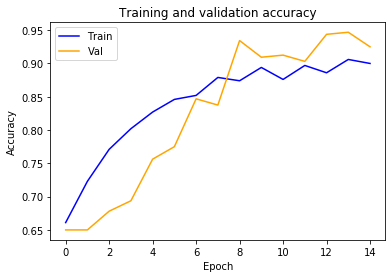

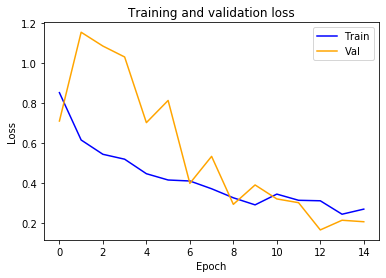

In [16]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.title('Training and validation accuracy')
plt.plot(epochs, acc, color='blue', label='Train')
plt.plot(epochs, val_acc, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

_ = plt.figure()
plt.title('Training and validation loss')
plt.plot(epochs, loss, color='blue', label='Train')
plt.plot(epochs, val_loss, color='orange', label='Val')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

In [17]:
loss, acc = model.evaluate_generator(test_ds)
print(loss, acc)

0.24380749789997935 0.9275


In [0]:
# delet unnecessary information
del train_ds, validation_ds, test_ds

heat map

check if a patch has cancer by check the center region of the patch, 128*128 if has cancer. 

In [0]:
def check_cancer(x,y,mask,levelnum):
  centersize = 128
  df = pow(2,levelnum)
  center_x = x-centersize//2
  center_y = y-centersize//2
  mask_center = read_slide(mask, x=center_x * df, y= center_y * df, level=levelnum, width=128, height=128)
  if mask_center.any():
    a = 1     
  else: a = 0
  return a

I use each pixel in level 7 as the center of a patch on level 5 and predict that patch on the model. so we have predict value for each pixel on level 7 image. 

In [0]:
def get_prepatch(x,y,slide,levelnum):
  df = pow(2,levelnum)
  patchsize = 299
  corrdinate_x = x-patchsize//2
  corrdinate_y = y-patchsize//2
  region = read_slide(slide, x=corrdinate_x * df, y= corrdinate_y * df, level=levelnum, width=299, height=299)
  tissue_pixels = list(find_tissue_pixels(region))
  tissue_regions = apply_mask(region, tissue_pixels)

  return tissue_regions

In [28]:
pre = []
truelable = []
testlist = []
heat_x = []
heat_y = []

heat_img_list = ['110']
test_tumor_path = '/content/drive/My Drive/myslide/Copy of tumor_'+heat_img_list[0]+'.tif'
test_tumor_mask_path = '/content/drive/My Drive/myslide/Copy of tumor_'+heat_img_list[0]+'_mask.tif'
test_slide = open_slide(test_tumor_path)
test_mask = open_slide(test_tumor_mask_path)
slide_test = read_slide(test_slide, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_slide.level_dimensions[7][0], 
                        height=test_slide.level_dimensions[7][1])
mask_test = read_slide(test_mask, 
                        x=0, 
                        y=0, 
                        level=7, 
                        width=test_mask.level_dimensions[7][0], 
                        height=test_mask.level_dimensions[7][1])[:,:,0]
                        
tissue_pixels = list(find_tissue_pixels(slide_test))
tissue_regions = apply_mask(slide_test, tissue_pixels)
# plt.figure(figsize=(10,10), dpi=100)
# plt.imshow(tissue_regions)
# print(tissue_regions[:,:,0])
heatmap = np.zeros((test_slide.level_dimensions[7][1],test_slide.level_dimensions[7][0]))
count = 0
for x in range(100,test_slide.level_dimensions[7][1]-80,10):
  for y in range(120,test_slide.level_dimensions[7][0]-80,10):
    
    if tissue_regions[x,y,0] == 1 and count<2000:
        x5 = x*pow(2,2)
        y5 = y*pow(2,2)  #level 7 to level 5
        test_patch = get_prepatch(y5, x5, test_slide, 5)
        testlist.append(test_patch)
        heat_x.append(x)
        heat_y.append(y)
        true = check_cancer(y5, x5, test_mask, 5)
        truelable.append(true)
        count += 1
testlist = np.asarray(testlist)/255.0
predict = model.predict(testlist)
print(min(predict))




[6.520748e-05]


on the heatmap I only show the predict value is over 0.999. This is because that region is defintely bad.

In [0]:
heatmap = np.zeros((test_slide.level_dimensions[7][1],test_slide.level_dimensions[7][0]))
error = 0
for i in range(1,len(predict)):
  if predict[i]>0.9:
    heatmap[heat_x[i]-5:heat_x[i]+5,heat_y[i]-5:heat_y[i]+5] = 1
  # if 0.8<predict[i]<0.999:
  #   heatmap[heat_x[i]-5:heat_x[i]+5,heat_y[i]-5:heat_y[i]+5] = 0.2

    error += abs(truelable[i]-predict[i])

# print(error)
# print(heatmap.shape)

In [30]:
accurary = 1-error/len(predict)
print(accurary)

[0.9721173]


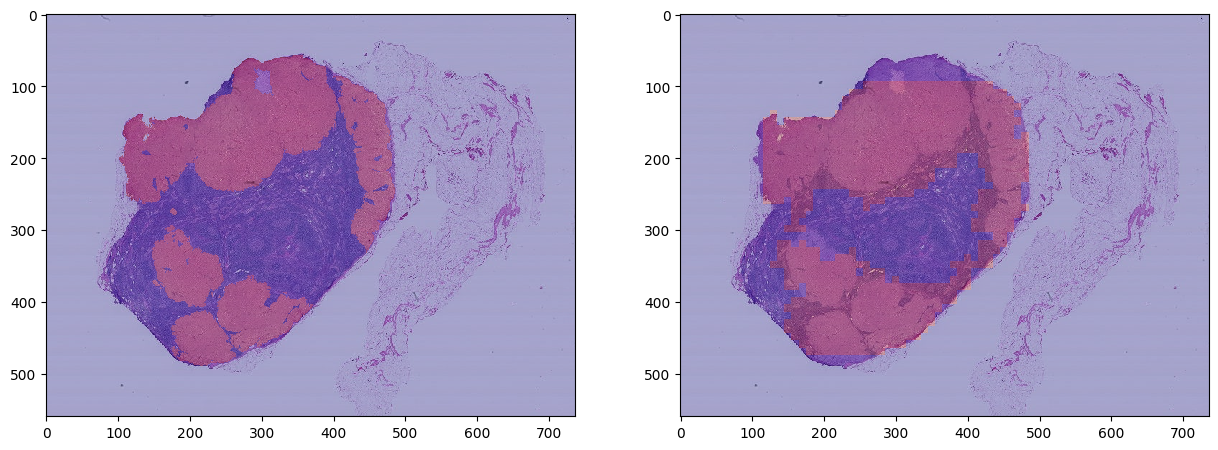

In [31]:
#draw heatmap

# heat = Normalize(0, 1)(heatmap)
fig, axes = plt.subplots(1,2, figsize=(15,15), dpi=100)
axes[0].imshow(slide_test)
axes[0].imshow(mask_test, cmap='jet', alpha=0.3)
axes[1].imshow(slide_test)
axes[1].imshow(heatmap, cmap='jet', alpha=0.3)

In [0]:
del predict, test_slide, test_mask, testlist